In [1]:
import pandas_datareader.data as web # 주가 데이터
import datetime # 날짜    
import matplotlib.pyplot as plt # 시각화 라이브러리
from statsmodels.tsa.stattools import adfuller # adf 테스트
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.arima import ndiffs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

C:\Users\rlatp\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# 특정 기간 내에 주식개장일 불러오기
import exchange_calendars as ecals
def get_open_dates(start,end):
    k = ecals.get_calendar("XKRX")
    df = pd.DataFrame(k.schedule.loc[start:end]) #["2022-11-01":"2023-10-31"])
    # print(df['open'])

    date_list = []
    for i in df['open']:
        date_list.append(i.strftime("%Y-%m-%d"))
       # print(i.strftime("%Y-%m-%d"))   
    date_index = pd.DatetimeIndex(date_list)
    return date_index  # DatetimeIndex

In [3]:
# forecast 함수
def forecast_n_step(model, n = 1):
    fc, conf_int = model.predict(n_periods=n, return_conf_int=True)
    #print("fc", fc,"conf_int", conf_int)
    return (
        fc.tolist()[0:n], np.asarray(conf_int).tolist()[0:n]
   )

def forecast(len, model, index, data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(len):
            fc, conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred, index=index), pred_upper, pred_lower

In [11]:
def Stock_Predict(stock, train_ratio=0.9):
    # 1. 주가 데이터 불러오기 
    start = datetime.datetime(2012, 10, 31) 
    end = datetime.datetime(2022, 10, 31) 
    
    stock_data = web.DataReader(stock,"yahoo",start,end)
    print('\033[34m'+'\033[1m' + '1. 주가 데이터 불러오기' + '\033[0m') # 글자색 변경, Bold체

    print('\033[31m'+'\033[1m' + 'Alphabet Inc. (GOOG) 주가 Historical Data' + '\033[0m') 
    print(stock_data)
    print(stock_data.info())
    print("\n")
    
    # 2. 데이터 전처리 & 원본시계열, 이동평균, 이동표준편차 시각화
    print('\033[34m'+'\033[1m' + '2. 데이터 전처리 & 원본시계열, 이동평균, 이동표준편차 시각화' + '\033[0m')
    # 전처리 - 거래량이 0인 일자 제거 & 수정종가 데이터만 사용
    data = stock_data['Adj Close'][stock_data['Volume'] != 0] 
    
    # 원본시계열, 이동평균, 이동표준편차 시각화 
    interval = 50 # 50일치 평균내어 이동평균계산
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    
    print('\033[31m'+'\033[1m' + '원본시계열, 이동평균, 이동표준편차 시각화' + '\033[0m') 
    plt.figure(figsize=(12, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # 3. ADF테스트 - 정상성 테스트
    print('\033[34m'+'\033[1m' + '3. ADF테스트 - 정상성 테스트' + '\033[0m')
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))
    print("\n")    
        
    # 4. ARIMA(p,d,q) 모수 추정
    print('\033[34m'+'\033[1m' + '4. ARIMA(p,d,q) 모수 추정' + '\033[0m')
    
    # ACF, PACF 검정
    print('\033[31m'+'\033[1m' + '방법1. ACF, PACF 검정' + '\033[0m') 
    plot_acf(data)
    plot_pacf(data, method='ywm')
    plt.show()
    print('\n')
    
    # ndiffs, auto_arima
    print('\033[31m'+'\033[1m' + '방법2. ndiffs, auto_arima 함수 사용' + '\033[0m') 
    n_diffs  = ndiffs(data, alpha=0.05, test='adf', max_d=6)
    print(f"\t 추정된 차수 d = {n_diffs }") 
    # 원본 데이터에 대한 모수 자동 측정!     
    model_fit = pm.auto_arima(
            y=data, 
            d=n_diffs , 
            start_p=0, max_p=2, 
            start_q=0, max_q=2, 
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
    )
    print("AIC: ", model_fit.aic())
    print("\n")
    
    # 5. 잔차검정
    print('\033[34m'+'\033[1m' + '5. 잔차검정' + '\033[0m')
    print('\033[31m'+'\033[1m' + '잔차에 대한 검정 통계량' + '\033[0m') 
    print(model_fit.summary())

    print('\033[31m'+'\033[1m' + '잔차의 정상성, 정규성 그래프' + '\033[0m') 
    model_fit.plot_diagnostics(figsize=(16,8))
    plt.show()
    
    # 6. ARIMA 모델학습과 성능평가
    print('\033[34m'+'\033[1m' + '6. ARIMA 모델학습과 성능평가' + '\033[0m')
    print('\033[31m'+'\033[1m' + 'train_data 적합' + '\033[0m') 
    train_data, test_data = data[:int(len(data)*train_ratio)], data[int(len(data)*train_ratio):]
    model_fit = pm.auto_arima(
            y=train_data, 
            d=n_diffs , 
            start_p=1, max_p=1, 
            start_q=0, max_q=0,  # ARIMA (1,1,0) 으로 파라미터 제한
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
    )
    print(model_fit.summary())
    print("\n")
    
    print('\033[31m'+'\033[1m' + 'test_data와 예측값 비교' + '\033[0m') 
    # Forecast 
    fc, upper, lower = forecast(len(test_data), model_fit, test_data.index, data = test_data)
    
    # pandas series 생성
    # fc # 예측결과
    lower_series = pd.Series(lower, index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(upper, index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(20,6))
    plt.plot(train_data, label='train_data')
    plt.plot(test_data, c='b', label='test_data (actual price)')
    plt.plot(fc, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend(loc='upper left')
    plt.show()
    
    # 모델의 오차율 계산
    print('\033[31m'+'\033[1m' + '모델의 오차율 계산(성능평가)' + '\033[0m') 
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)
    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)
    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)
    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: ' ,'{:.2f}%'.format(mape*100))
    print('\n')
    
    # 7. 향후 1년 주가 예측
    print('\033[34m'+'\033[1m' + '7. 1년 후 주가 예측' + '\033[0m')
    date_index = get_open_dates("2022-11-01","2023-10-31")
    fc2, upper2, lower2 = forecast(len(date_index), model_fit, date_index)
    # fc2, conf = forecast_n_step(model_fit, len(date_list))
    lower_series2 = pd.Series(lower2, index=date_index)  # 예측결과의 하한 바운드
    upper_series2 = pd.Series(upper2, index=date_index)  # 예측결과의 상한 바운드
    print("")
    print('\033[31m'+'\033[1m' + '1년 후 {} 주가'.format(stock) + '\033[0m') 
    print(fc2.tail())
    print("\n")
    
    print('\033[31m'+'\033[1m' + '시각화' + '\033[0m') 
    plt.figure(figsize=(20,6))
    plt.plot(train_data, label='original')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc, c='r',label='predicted price')
    plt.plot(fc2, c='g',label='forward predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.10)
    plt.title('After 1 year')
    plt.legend(loc='upper left')
    plt.show()
    

1. 주가 데이터 불러오기
Alphabet Inc. (GOOG) 주가 Historical Data
                  High         Low        Open       Close      Volume  \
Date                                                                     
2012-10-31   16.961424   16.811985   16.933031   16.943991  61710442.0   
2012-11-01   17.208000   16.904636   16.924065   17.125559  82311371.0   
2012-11-02   17.323816   17.120081   17.304888   17.133778  93324497.0   
2012-11-05   17.107376   16.825932   17.048597   17.010241  65681270.0   
2012-11-06   17.098412   16.875496   17.073006   16.979357  63549309.0   
...                ...         ...         ...         ...         ...   
2022-10-25  105.099998  103.019997  103.300003  104.930000  29910200.0   
2022-10-26   98.540001   94.570000   96.760002   94.820000  71504300.0   
2022-10-27   95.169998   91.900002   94.309998   92.599998  54036500.0   
2022-10-28   96.860001   92.322998   92.529999   96.580002  35696900.0   
2022-10-31   96.349998   94.379997   95.779999   94.66000

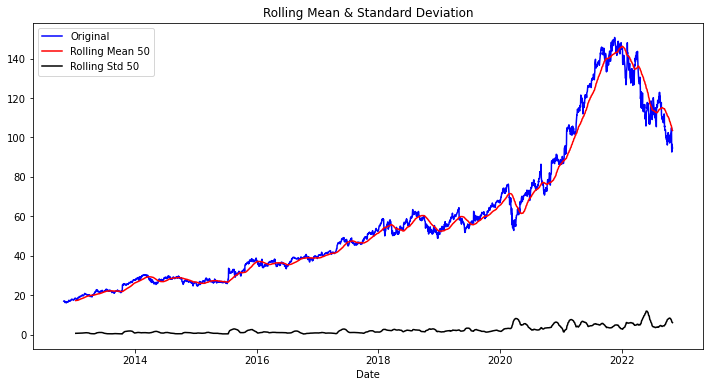

3. ADF테스트 - 정상성 테스트
ADF Statistics: -0.810527
p-value: 0.816010
num of lags: 24.000000
num of observations: 2493.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


4. ARIMA(p,d,q) 모수 추정
방법1. ACF, PACF 검정


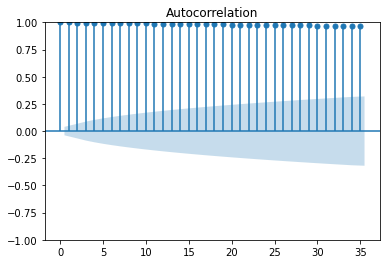

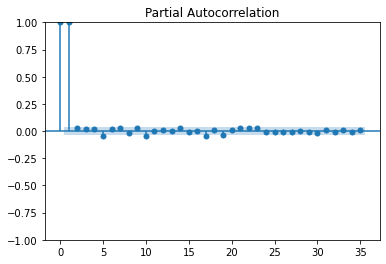



방법2. ndiffs, auto_arima 함수 사용
	 추정된 차수 d = 1
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8236.297, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8225.926, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8225.992, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8235.853, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8227.885, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8227.311, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8229.054, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8225.720, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8227.665, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8227.039, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8225.803, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8228.808, Time=0.36 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.222 seconds
AIC:  8225.72011859249


5. 잔차검정
잔차에 대한 검

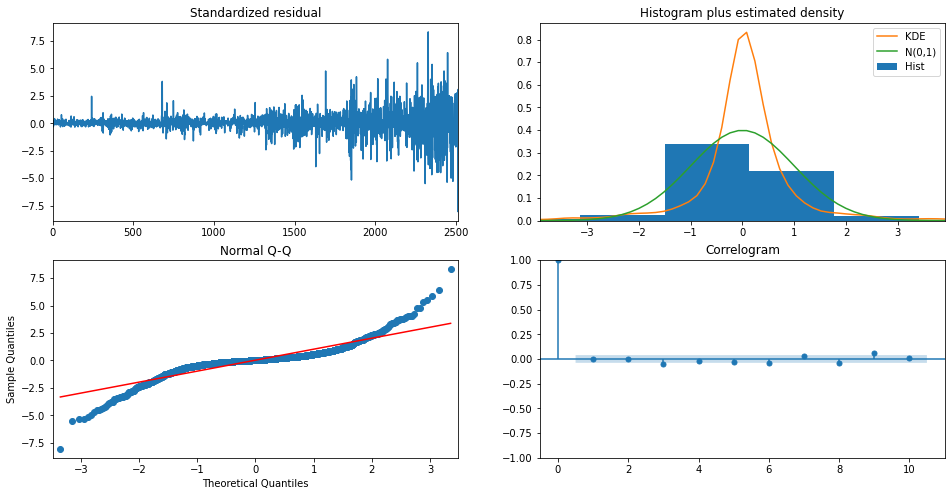

6. ARIMA 모델학습과 성능평가
train_data 적합
Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6125.677, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6134.281, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6140.948, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6133.555, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.547 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2266
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3059.839
Date:                Sun, 06 Nov 2022   AIC                           6125.677
Time:                        23:21:59   BIC                           6142.853
Sample:                             0   HQIC                          6131.944
                               - 2266                                         
Covariance Type:             

C:\Users\rlatp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


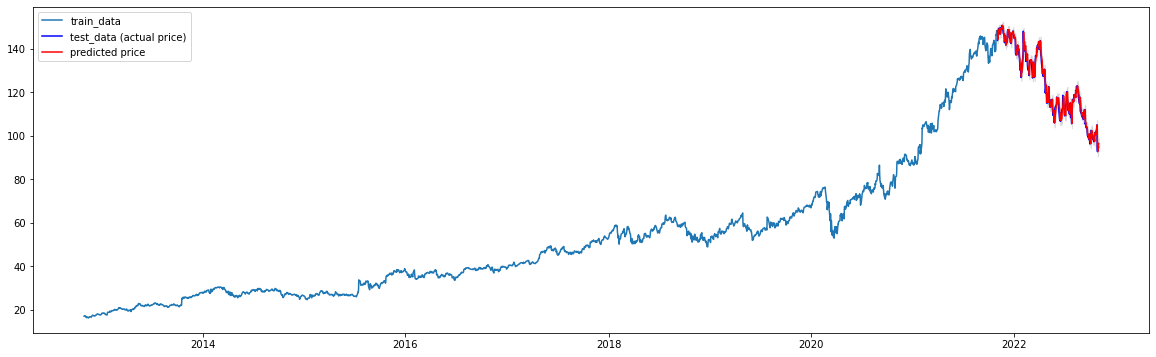

모델의 오차율 계산(성능평가)
MSE:  4.318890593663584e+128
MAE:  4.089473332183712e+63
RMSE:  2.078194070259942e+64
MAPE:  11371.32%


7. 1년 후 주가 예측

1년 후 GOOG 주가
2023-10-25    102.362737
2023-10-26    102.393655
2023-10-27    102.424573
2023-10-30    102.455491
2023-10-31    102.486410
dtype: float64


시각화


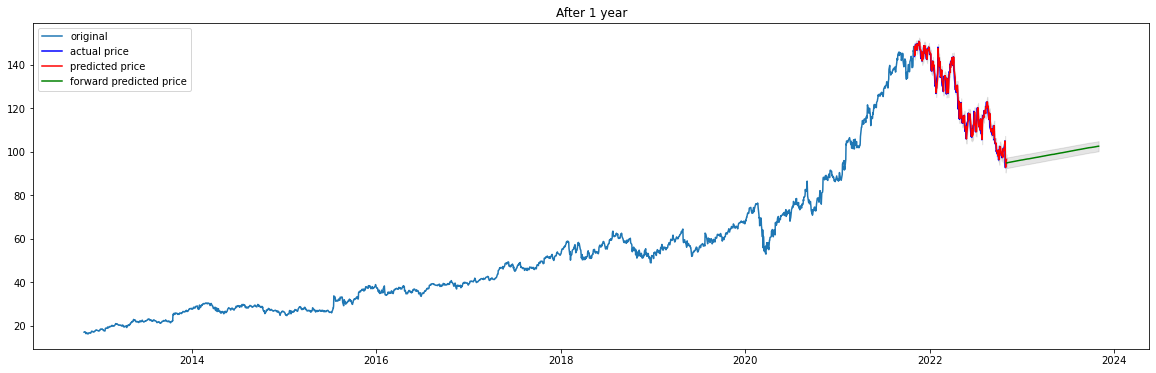

In [12]:
# 함수 실행
# 구글 주가, train set비율 : 0.9
Stock_Predict("GOOG", 0.9)